# 1. deploy_sam_on_sagemaker.ipynb
---
이 예제는 https://github.com/facebookresearch/segment-anything 를 SageMaker에서 배포하여 쉽게 segmentation을 수행할 수 있도록 합니다.
이제 **SageMaker 모델 호스팅 서비스인 SageMaker 엔드포인트**에 모델을 배포할 준비가 되었습니다. 


In [1]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
sagemaker.__version__

'2.210.0'

In [3]:
%load_ext autoreload
%autoreload 2

<br>

## 0. Prepare Your Model
---
SageMaker에서 사용하게 될 모델 weight를 다운로드 받습니다.

In [4]:
!sudo rm -rf ./model

In [5]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./model

--2024-03-24 05:12:42--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 143.204.86.53, 143.204.86.117, 143.204.86.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|143.204.86.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘./model/sam_vit_h_4b8939.pth’

100%[====================================>] 2,564,550,879  152MB/s   in 15s    

2024-03-24 05:12:56 (168 MB/s) - ‘./model/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



`Session()`은 AWS 환경에 접속하는 접속 정보와 SageMaker에서 사용하는 리소스를 관리하기 위한 편리한 방법을 제공합니다. 

In [6]:
import boto3
import sagemaker
import json

sess = sagemaker.Session()
sm_session = sagemaker.session.Session()
boto_session = boto3.session.Session()
sm_client = boto3.client("sagemaker")
bucket = sm_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto_session.region_name

print((bucket, role))

('sagemaker-ap-northeast-1-868746300942', 'arn:aws:iam::868746300942:role/service-role/AmazonSageMaker-ExecutionRole-20240323T191629')


<br>

## 1. Create Model Serving Script

---

아래 코드 셀은 src 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

#### Option 1.
- `model_fn(model_dir)`: S3의 `model_dir`에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. `content_type`은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: `application/x-npy`, `application/json`, `application/csv`등)
- `predict_fn(input_object, model)`: `input_fn(...)`을 통해 들어온 데이터에 대해 추론을 수행합니다.
- `output_fn(prediction, accept_type)`: `predict_fn(...)`에서 받은 추론 결과를 후처리를 거쳐 프론트엔드로 전송합니다.

#### Option 2.
- `model_fn(model_dir)`: S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: `input_fn(...), predict_fn(...), output_fn(...)`을 `transform_fn(...)`으로 통합할 수 있습니다.

In [7]:
!cd model && sudo rm -rf /code && mkdir code

In [8]:
%%writefile model/code/requirements.txt
git+https://github.com/facebookresearch/segment-anything.git

Writing model/code/requirements.txt


In [9]:
%%writefile model/code/inference.py
import json
import base64
import numpy as np
from io import BytesIO
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry

def _encode(image):
    img = image
    img_byte_arr = BytesIO()
    img.save(img_byte_arr, format="PNG")
    img_byte_arr = img_byte_arr.getvalue()
    img_byte_arr = base64.b64encode(img_byte_arr).decode()
    return img_byte_arr


def _decode(image):
    image = base64.b64decode(image)
    image = Image.open(BytesIO(image))
    return image


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    print("--------------- model_fn Start ---------------")
    sam = sam_model_registry["vit_h"](checkpoint=model_dir + "/sam_vit_h_4b8939.pth")
    sam.to(device='cuda')
    
    predictor = SamPredictor(sam)
    print("--------------- model_fn End ---------------")
    return predictor
                     

def input_fn(data, request_content_type):
    """
    The SageMaker XGBoost model server receives the request data body and the content type,
    and invokes the `input_fn`.
    Return a DMatrix (an object that can be passed to predict_fn).
    """
    print("Content type: ", request_content_type)
    if request_content_type == "application/json":        
        input_data = json.loads(data)
        face_image = _decode(input_data["encode_image"])
        numpy_image = np.array(face_image)
        input_box = np.array(input_data["input_box"])
        return (numpy_image, input_box)
    else:
        raise ValueError(
            "Content type {} is not supported.".format(request_content_type)
        )
        

def predict_fn(input_data, predictor):
    """
    SageMaker model server invokes `predict_fn` on the return value of `input_fn`.
    Return a two-dimensional NumPy array (predictions and scores)
    """
    
    numpy_image = input_data[0]
    input_box = input_data[1]
    input_label = np.array([0])
    
    predictor.set_image(numpy_image)
    masks, _, _ = predictor.predict(box=input_box,
                                    point_labels=input_label,
                                    multimask_output=False)
    
    return masks


def output_fn(masks, content_type="application/json"):
    """
    After invoking predict_fn, the model server invokes `output_fn`.
    """
    mask = (np.array(masks[0])) * 255.0
    mask = 255 - mask
    mask_img = Image.fromarray(mask)
    mask_img = mask_img.convert('RGB')    
    
    image_final = _encode(mask_img)

    return json.dumps({"mask_image": image_final})

Writing model/code/inference.py


<br>

## 2. Deploy a trained model from Amazon S3
---

SageMaker API의 `Model` 클래스는 훈련한 모델을 서빙하기 위한 모델 아티팩트와 도커 이미지를 정의합니다. 
`Model` 클래스 인스턴스 호출 시 AWS에서 사전 빌드한 도커 이미지 URL을 직접 가져올 수도 있지만, Model의 자식 클래스로(예: `XGBoostModel`, `TensorFlowModel`) 초기화하면 파라메터에 버전만 지정하는 것만으로 편리하게 추론을 수행하는 환경을 정의할 수 있습니다.

### Upload model/source artifacts to S3
압축한 모델 아티팩트를 Amazon S3로 복사합니다.

In [10]:
prefix = 'sam/deploy'
s3_model_path = f's3://{bucket}/{prefix}/model.tar.gz'
!cd model && tar -czvf model.tar.gz sam_vit_h_4b8939.pth ./code && mv model.tar.gz ../
!aws s3 cp model.tar.gz {s3_model_path}
!rm -rf model.tar.gz

sam_vit_h_4b8939.pth
./code/
./code/requirements.txt
./code/inference.py
upload: ./model.tar.gz to s3://sagemaker-ap-northeast-1-868746300942/sam/deploy/model.tar.gz


In [11]:
# ecr_image_uri = '763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310-cu118-ubuntu20.04-sagemaker'
ecr_image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch', 
    version='2.1.0',
    instance_type='ml.g4dn.2xlarge',
    region=region, 
    image_scope='inference'
)

In [12]:
import base64
import boto3
import copy
from PIL import Image
from io import BytesIO


import os
import numpy as np
import matplotlib.pyplot as plt


from botocore.config import Config

def encode_image(image, formats="PNG"):
    buffer = BytesIO()
    image.save(buffer, format=formats)
    img_str = base64.b64encode(buffer.getvalue())
    return img_str


def decode_image(img):
    img = img.encode("utf8") if type(img) == "bytes" else img
    buff = BytesIO(base64.b64decode(img))
    image = Image.open(buff)
    return image


def label_list():
    import pandas as pd
    pd.set_option('display.max_columns', 150)
    pd.set_option('display.max_colwidth', None)
    
    ## 모델 별 label list : https://docs.aws.amazon.com/rekognition/latest/dg/labels.html
    label_path = '../AmazonRekognitionBoundingBoxLabels_v3.0.csv'

    csv_file = pd.read_csv(label_path)
    label_lists = list(csv_file['Label'].values)
    
    label_table = {}
    label_cnt = {}
    max_cnt = 0
    for label_item in label_lists:
        start_char = label_item[0]
        # print(start_char)
        if label_table.get(start_char):
            label_table[start_char].append(label_item)
            label_cnt[start_char] += 1
            if max_cnt < label_cnt[start_char]:
                max_cnt = label_cnt[start_char]
        else:
            label_table[start_char] = [label_item]
            label_cnt[start_char] = 1

    for start_char in label_cnt:
        iter_cnt = max_cnt - label_cnt[start_char]
        for _ in range(iter_cnt):
            label_table[start_char].append('-')

    return pd.DataFrame(label_table)


def boto3_runtime(service_name, target_region):
    session_kwargs = {"region_name": target_region}
    client_kwargs = {**session_kwargs}

    retry_config = Config(
        region_name=target_region,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    session = boto3.Session(**session_kwargs)

    boto3_runtime = session.client(
        service_name=service_name,
        config=retry_config,
        **client_kwargs
    )
    
    return boto3_runtime


def show_faces(img_path, target_region='us-west-2'):
    client = boto3_runtime(
        service_name='rekognition',
        target_region=target_region
    )

    image = Image.open(img_path).convert('RGB')
    image = img_resize(image)

    buffer = BytesIO()
    image.save(buffer, format='jpeg', quality=100)
    val = buffer.getvalue()

    response = client.detect_faces(Image={'Bytes': val},Attributes=['ALL'])

    imgWidth, imgHeight = image.size       
    ori_image = copy.deepcopy(image)

    for faceDetail in response['FaceDetails']:
        print('The detected face is between ' + str(faceDetail['AgeRange']['Low']) 
              + ' and ' + str(faceDetail['AgeRange']['High']) + ' years old')

        box = faceDetail['BoundingBox']
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']

        print(f"imgWidth : {imgWidth}, imgHeight : {imgHeight}")
        print('Left: ' + '{0:.0f}'.format(left))
        print('Top: ' + '{0:.0f}'.format(top))
        print('Face Width: ' + "{0:.0f}".format(width))
        print('Face Height: ' + "{0:.0f}".format(height))

    return ori_image, imgWidth, imgHeight, int(left), int(top), int(width), int(height), response


def show_labels(img_path, target_label=None, target_region='us-west-2'):
    client = boto3_runtime(
        service_name='rekognition',
        target_region=target_region
    )
    
    if target_label is None:
        Settings = {"GeneralLabels": {"LabelInclusionFilters":[]},"ImageProperties": {"MaxDominantColors":1}}
        # print(f"target_label_None : {target_label}")
    else:
        Settings = {"GeneralLabels": {"LabelInclusionFilters":[target_label]},"ImageProperties": {"MaxDominantColors":1}}
        # print(f"target_label : {target_label}")
    
    box = None
    
    image = Image.open(img_path).convert('RGB')
    image = img_resize(image)

    buffer = BytesIO()
    image.save(buffer, format='jpeg', quality=100)
    val = buffer.getvalue()
    
    response = client.detect_labels(Image={'Bytes': val},
                                    MaxLabels=15,
                                    MinConfidence=0.7,
                                    # Uncomment to use image properties and filtration settings
                                    Features=["GENERAL_LABELS", "IMAGE_PROPERTIES"],
                                    Settings=Settings
                                   )

    imgWidth, imgHeight = image.size       
    ori_image = copy.deepcopy(image)
    color = 'white'

    for item in response['Labels']:
        # print(item)
        if len(item['Instances']) > 0:
            print(item)
            print(item['Name'], item['Confidence'])

            for sub_item in item['Instances']:
                color = sub_item['DominantColors'][0]['CSSColor']
                box = sub_item['BoundingBox']
                break
        break
    try:
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']

        print(f"imgWidth : {imgWidth}, imgHeight : {imgHeight}")
        print('Left: ' + '{0:.0f}'.format(left))
        print('Top: ' + '{0:.0f}'.format(top))
        print('Object Width: ' + "{0:.0f}".format(width))
        print('Object Height: ' + "{0:.0f}".format(height))
        return ori_image, imgWidth, imgHeight, int(left), int(top), int(width), int(height), color, response
    except:
        print("There is no target label in the image.")
        return _, _, _, _, _, _, _, _, _


def boto3_runtime(service_name, target_region=boto3.Session().region_name):
    session_kwargs = {"region_name": target_region}
    client_kwargs = {**session_kwargs}

    retry_config = Config(
        region_name=target_region,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    session = boto3.Session(**session_kwargs)

    boto3_runtime = session.client(
        service_name=service_name,
        config=retry_config,
        **client_kwargs
    )
    
    return boto3_runtime


def img_resize(image):
    imgWidth, imgHeight = image.size 
    
    max_length = 512

    if imgWidth < imgHeight:
        imgWidth = int(max_length/imgHeight*imgWidth)
        imgWidth = imgWidth-imgWidth%64
        imgHeight = max_length
    else:
        imgHeight = int(max_length/imgWidth*imgHeight)
        imgHeight = imgHeight-imgHeight%64
        imgWidth = max_length 

    image = image.resize((imgWidth, imgHeight), resample=0)
    return image


def image_to_base64(img) -> str:
    """Converts a PIL Image or local image file path to a base64 string"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

<br>

## 2.1. Deploy to Local Environment: Model class

SageMaker 호스팅 엔드포인트로 배포하기 전에 로컬 모드 엔드포인트로 배포할 수 있습니다. 로컬 모드는 현재 개발 중인 환경에서 도커 컨테이너를 실행하여 SageMaker 프로세싱/훈련/추론 작업을 에뮬레이트할 수 있습니다. 추론 작업의 경우는 Amazon ECR의 딥러닝 프레임워크 기반 추론 컨테이너를 로컬로 가져오고(docker pull) 컨테이너를 실행하여(docker run) 모델 서버를 시작합니다.

아래 코드를 보시면 아시겠지만, 지속적으로 업데이트되는 파이썬 버전&프레임워크 버전&트랜스포머 버전에 쉽게 대응할 수 있습니다. AWS에서 관리하고 있는 딥러닝 컨테이너(DLC) 목록을 아래 주소에서 확인해 보세요.
- https://github.com/aws/deep-learning-containers/blob/master/available_images.md

#### Create Model

In [13]:
instance_type='local_gpu'

In [14]:
from pathlib import Path
import time

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    from sagemaker.local import entities
    # entities.HEALTH_CHECK_TIMEOUT_LIMIT=300  
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    
    model_data_url=f"file://{Path.cwd()}/model"
    model_data=f"file://{Path.cwd()}/model.tar.gz"
else:
    sagemaker_session = sagemaker.session.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data_url=s3_model_path
    
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"sam-model-{ts}"
endpoint_config_name = f"sam-endpoint-config-{ts}"
endpoint_name = f"sam-endpoint-{ts}"

In [15]:
local_container = {
   "Image": ecr_image_uri,
   "ModelDataUrl" : model_data_url,
   "ModelDataSource": {
           "S3DataSource": {
               "S3Uri": model_data_url,
               "S3DataType": "S3Prefix",
               "CompressionType": "None",  ## local
           },
       },
   "Environment": {}
}

In [16]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=local_container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            "ContainerStartupHealthCheckTimeoutInSeconds": 3600,
        }
    ],
)

In [17]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [18]:
# !docker kill 6f6a5ef17e66

In [20]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

In [21]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [22]:
label_list()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,Z
0,Adult,Baby,Camera,Dagger,E-scooter,Face,Gas Pump,Hammer,Ice Cream,Jacket,Kangaroo,Lamp,Mace Club,Necklace,Orange,Package,QR Code,Rat,Sandal,T-Shirt,Utility Pole,Vest,Wallet,Zebra
1,Airplane,Backpack,Can,Desk,Earbuds,Female,Gate,Handbag,Ice Hockey Puck,Jeans,Kayak,Laptop,Mailbox,Notebook,Overcoat,Painting,-,Razor,Sandwich,Tablet Computer,-,Violin,Washer,-
2,Altar,Balloon,Candle,Diamond,Earring,Field Hockey Stick,Giant Panda,Handcuffs,Ice Hockey Stick,-,Ketchup,Lawn Mower,Male,-,-,Pajamas,-,Refrigerator,Scarf,Tank,-,Volleyball (Ball),Wedding Cake,-
3,American Football (Ball),Banana,Canoe,Diaper,Egg,Fire Hydrant,Giraffe,Hanukkah Menorah,Id Cards,-,Kitchen Island,License Plate,Man,-,-,Panther,-,Remote Control,Scissors,Tape,-,VR Headset,Wedding Gown,-
4,Antelope,Baseball (Ball),Car,Dining Table,Elephant,Fire Truck,Girl,Hardhat,Insect,-,Knife,Lifejacket,Microphone,-,-,Pants,-,Ring,Scoreboard,Tattoo,-,-,Wheel,-
5,Apple,Baseball Bat,Cat,Dinosaur,-,Fireplace,Glasses,Hat,-,-,-,Lighthouse,Microwave,-,-,Passport,-,Road Sign,Screw,Teddy Bear,-,-,White Board,-
6,Arrow,Baseball Cap,Ceiling Fan,Disk,-,First Aid,Glove,Head,-,-,-,Limo,Milk,-,-,Pear,-,Rocket,Screwdriver,Teen,-,-,Windmill,-
7,Axe,Baseball Glove,Chair,Disposable Cup,-,Fish,Grenade,Headphones,-,-,-,Lion,Mixer,-,-,Pen,-,Rose,Shaker,Tennis Ball,-,-,Woman,-
8,-,Basketball (Ball),Chandelier,Document,-,Flag,Guitar,Helicopter,-,-,-,Lipstick,Mobile Phone,-,-,Penguin,-,Rug,Shark,Tennis Racket,-,-,Wristwatch,-
9,-,Bathtub,Cheetah,Dog,-,Flyer,Gun,Helmet,-,-,-,Lizard,Monitor,-,-,Perfume,-,Rugby Ball,Sheep,Tent,-,-,-,-


In [26]:
img_path = f'../test_images/andy_portrait_2.jpg' ## 원하는 이미지를 선택합니다.
target_label = None
# target_label="Car"

In [33]:
%%time
ext = img_path.split('.')[-1]
if ext == 'jpg':
    ext = 'jpeg'


if target_label == None:
    object_image, width, height, f_left, f_top, f_width, f_height, human_res = show_faces(img_path) ## detect_faces
else:
    object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path, target_label=target_label)

The detected face is between 53 and 61 years old
imgWidth : 512, imgHeight : 256
Left: 212
Top: 41
Face Width: 92
Face Height: 126
CPU times: user 63.3 ms, sys: 19.2 ms, total: 82.6 ms
Wall time: 977 ms


In [34]:
import numpy as np

encode_object_image = encode_image(object_image,formats="PNG").decode("utf-8")

inputs = dict(
    encode_image = encode_object_image,
    input_box = [f_left, f_top, f_left+f_width, f_top+f_height]
)

In [36]:
def invoke_endpoint(endpoint_name, payload):

    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/json",
        Body=json.dumps(payload)
    )
    data = response["Body"].read().decode("utf-8")
    return data

predictions = invoke_endpoint(endpoint_name, inputs)

mask_image = decode_image(json.loads(predictions)['mask_image'])
mask_image

#### Check Docker

모델 서빙을 위한 도커 컨테이너가 구동되고 있음을 확인할 수 있습니다.

In [37]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [38]:
# !docker kill a110dfb8db5e

#### Local Mode Endpoint Clean-up

In [39]:
try:
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    sm_client.delete_model(ModelName=sm_model_name)
except:
    print("If any docker processes are running,Retry this cell, please.")
finally:
    !docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


<br>

## 2.2. Deploy to Hosting Instance

로컬 모드에서 충분히 디버깅했으면 실제 호스팅 인스턴스로 배포할 차례입니다. 코드는 거의 동일하며, `instance_type`만 다르다는 점을 주목해 주세요! 

#### Create Model

In [40]:
instance_type='ml.g4dn.xlarge'

In [41]:
from pathlib import Path
import time

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    from sagemaker.local import entities
    # entities.HEALTH_CHECK_TIMEOUT_LIMIT=300  
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    
    model_data_url=f"file://{Path.cwd()}/model"
    model_data=f"file://{Path.cwd()}/model.tar.gz"
else:
    sagemaker_session = sagemaker.session.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data_url=s3_model_path
    
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"sam-model-{ts}"
endpoint_config_name = f"sam-endpoint-config-{ts}"
endpoint_name = f"sam-endpoint-{ts}"

In [35]:
container = {
    "Image": ecr_image_uri,
    "ModelDataSource": {
            "S3DataSource": {
                "S3Uri": model_data_url,
                "S3DataType": "S3Object",
                "CompressionType": "Gzip", ## SageMaker Hosting
            },
        },
    "Environment": {}
}

In [36]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            # "ContainerStartupHealthCheckTimeoutInSeconds": 600
        }
    ]
)

#### Create Endpoint

In [37]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, 
    EndpointConfigName=endpoint_config_name
)

### Wait for the endpoint jobs to complete

엔드포인트가 생성될 때까지 기다립니다. 엔드포인트가 가리키는 호스팅 리소스를 프로비저닝하는 데에 몇 분의 시간이 소요됩니다. 

In [38]:
sess.wait_for_endpoint(endpoint_name, poll=5)

---------------------------------------------------------!

{'EndpointName': 'sam-endpoint-2024-03-24-03-45-27',
 'EndpointArn': 'arn:aws:sagemaker:ap-northeast-1:868746300942:endpoint/sam-endpoint-2024-03-24-03-45-27',
 'EndpointConfigName': 'sam-endpoint-config-2024-03-24-03-45-27',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/pytorch-inference:2.1.0-gpu-py310',
     'ResolvedImage': '763104351884.dkr.ecr.ap-northeast-1.amazonaws.com/pytorch-inference@sha256:d6344a1c254a71cae1f39de2d2ec72022e42209ee487ee83dca4a2bdd11bee02',
     'ResolutionTime': datetime.datetime(2024, 3, 24, 3, 46, 56, 702000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 3, 24, 3, 46, 55, 944000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 3, 24, 3, 51, 48, 413000, tzinfo=tzlocal()),
 'ResponseMet

In [39]:
%store endpoint_name img_path ecr_image_uri model_data_url

Stored 'endpoint_name' (str)
Stored 'img_path' (str)
Stored 'ecr_image_uri' (str)
Stored 'model_data_url' (str)


In [42]:
endpoint_name = 'sam-endpoint-2024-03-24-03-45-27'

In [43]:
def invoke_endpoint(endpoint_name, payload):
    smr_client = boto3.client("sagemaker-runtime")
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/json",
        Body=json.dumps(payload)
    )
    data = response["Body"].read().decode("utf-8")
    return data

## 3. Amazon Bedrock Titan Image Generation

In [44]:
modelId = "amazon.titan-image-generator-v1"
result_path = "./result"
seed = 43
cfgScale = 7.5
# height = 1152
# width = 768
resize_yn = False

In [53]:
# img_path = f'../test_images/andy_portrait_2.jpg' ## 원하는 이미지를 선택합니다.

outpaint_prompt = 'forrest'
target_label = None
# target_label = "Car"

In [59]:
%%time
ext = img_path.split('.')[-1]
if ext == 'jpg':
    ext = 'jpeg'

if target_label == None:
    object_image, width, height, f_left, f_top, f_width, f_height, human_res = show_faces(img_path) ## detect_faces
    text_prompt =  f'a human with a {outpaint_prompt} background'
else:
    object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path, target_label=target_label)
    text_prompt =  f'a {target_label} with a {outpaint_prompt} and {color} background'

{'Name': 'Car', 'Confidence': 99.88134765625, 'Instances': [{'BoundingBox': {'Width': 0.372697114944458, 'Height': 0.20702572166919708, 'Left': 0.19972412288188934, 'Top': 0.6443532109260559}, 'Confidence': 99.88134765625, 'DominantColors': [{'Red': 0, 'Blue': 0, 'Green': 0, 'HexCode': '#000000', 'CSSColor': 'black', 'SimplifiedColor': 'black', 'PixelPercent': 34.64836883544922}]}], 'Parents': [{'Name': 'Transportation'}, {'Name': 'Vehicle'}], 'Aliases': [{'Name': 'Automobile'}], 'Categories': [{'Name': 'Vehicles and Automotive'}]}
Car 99.88134765625
imgWidth : 512, imgHeight : 320
Left: 102
Top: 206
Object Width: 191
Object Height: 66
CPU times: user 824 ms, sys: 276 ms, total: 1.1 s
Wall time: 2.33 s


In [60]:
%%time
encode_object_image = encode_image(object_image,formats=ext.upper()).decode("utf-8")
inputs = dict(
    encode_image = encode_object_image,
    input_box = [f_left, f_top, f_left+f_width, f_top+f_height]
)

predictions = invoke_endpoint(endpoint_name, inputs)
mask_image = decode_image(json.loads(predictions)['mask_image'])

CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 1.71 s


In [61]:
os.makedirs('../result/', exist_ok=True)
image_name = img_path.split('/')[-1]
mask_image.save(f'../result/generated_{image_name}')

In [62]:
%%time
object_img = img_resize(object_image)
mask_img = img_resize(mask_image)

print(f"outpaint_prompt : {outpaint_prompt}, seed : {seed}")
# Payload creation
body = json.dumps({
    "taskType": "OUTPAINTING",
    "outPaintingParams": {
        "text": text_prompt,              # Optional
        # "negativeText": negative_prompts,    # Optional
        "image": image_to_base64(object_img),      # Required
        # "maskPrompt": mask_prompt,               # One of "maskImage" or "maskPrompt" is required
        "maskImage": image_to_base64(mask_img),  # Input maskImage based on the values 0 (black) or 255 (white) only
    },                                                 
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "premium",
        # "quality": "standard",
        "cfgScale": cfgScale,
        # "height": height,
        # "width": width,
        "seed": seed
    }
})

# Model invocation
boto3_bedrock = boto3_runtime(
    service_name='bedrock-runtime',
    target_region="us-west-2"
)

response = boto3_bedrock.invoke_model(
    body=body,
    modelId=modelId,
    accept="application/json", 
    contentType="application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
img_b64 = response_body["images"][0]
print(f"Output: {img_b64[0:80]}...")

# Decode + save
img_result = Image.open(
    BytesIO(
        base64.decodebytes(
            bytes(img_b64, "utf-8")
        )
    )
)
if resize_yn:
    img_result = img_result.resize((360, 480), 0)
output_path = result_path + '/generated_'+img_path.split('/')[-1]
os.makedirs(result_path, exist_ok=True)
img_result.save(output_path)
print(f"Gnerating an image in {output_path}")

outpaint_prompt : forrest, seed : 43
Output: iVBORw0KGgoAAAANSUhEUgAAAgAAAAFACAIAAABFqlNcAAEAAElEQVR4nFz9TbJkyZIziAFQ8ygKyR5w...
Gnerating an image in ./result/generated_hyundai-ioniq-5-0621-exterior-01.jpg
CPU times: user 112 ms, sys: 15 ms, total: 127 ms
Wall time: 19.6 s


Text(0.5, 0.98, 'Image comparison')

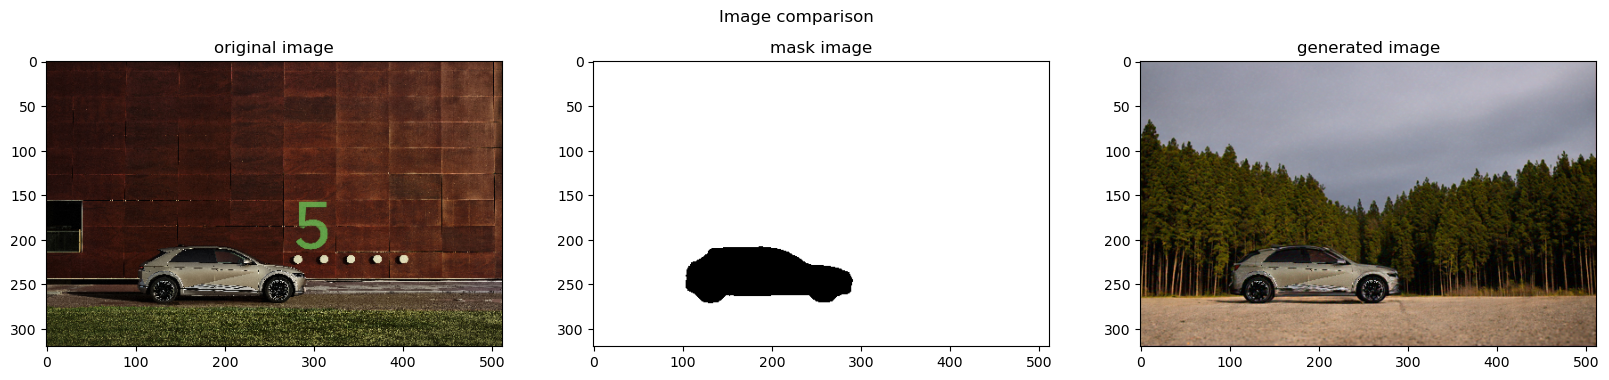

In [63]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.imshow(object_image)
plt.title('original image')

plt.subplot(1, 3, 2)
plt.imshow(mask_image)
plt.title('mask image')

plt.subplot(1, 3, 3)
plt.imshow(img_result)
plt.title('generated image')

plt.suptitle('Image comparison')

In [78]:
%%time
prompt = f"이미지에 대해 한국어로 설명을 해줘"
prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 4096,
    "temperature" : 0,
    "top_k": 350,
    "top_p": 0.999,
    "messages": [
        {
            "role": "user", "content": [
                {"type": "image", "source": {"type": "base64", "media_type": f"image/{ext}", "data": image_to_base64(object_image)}},
                {"type": "text", "text": prompt},
            ],
        }
    ],
}


body_text = json.dumps(prompt_config)

modelId_text = 'anthropic.claude-3-sonnet-20240229-v1:0'
response_text = boto3_bedrock.invoke_model(
    body=body_text,
    modelId=modelId_text,
    accept="application/json", 
    contentType="application/json"
)

import json
response_text_body = json.loads(response_text.get("body").read())
results = response_text_body.get("content")[0].get("text")

results

CPU times: user 54.4 ms, sys: 299 µs, total: 54.7 ms
Wall time: 4.37 s


'이 이미지는 벽돌 벽을 배경으로 잔디밭 위에 세워진 은색 스포츠 세단 차량을 보여주고 있습니다. 차량 옆에는 녹색 숫자 5가 크게 표시되어 있습니다. 이 장면은 차량 전시 또는 광고 촬영을 위한 것으로 보입니다. 단순하지만 차량의 스타일리시한 디자인과 숫자 5의 대비가 시선을 사로잡습니다.'

## Delete resource

In [115]:
# try:
#     sm_client.delete_endpoint(EndpointName=endpoint_name)
#     sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
#     sm_client.delete_model(ModelName=sm_model_name)
# except:
#     print("If any docker processes are running,Retry this cell, please.")

If any docker processes are running,Retry this cell, please.
